In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gym
from tqdm import tqdm_notebook
import numpy as np
from collections import deque

In [ ]:
#discount factor for future utilities
DISCOUNT_FACTOR = 0.99
gamma = 0.99
#number of episodes to run
NUM_EPISODES = 5000

#max steps per episode
MAX_STEPS = 10000

#score agent needs for environment to be solved
SOLVED_SCORE = 475

#device to run model on
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class PolicyNetwork(nn.Module):
  def __init__(self, observation_space, action_space,seed,layer_size):
        super(PolicyNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.input_layer = nn.Linear(observation_space, layer_size)
        self.output_layer = nn.Linear(layer_size, action_space)
  def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)
        actions = self.output_layer(x)
        action_probs = F.softmax(actions, dim=-1)
        return action_probs

In [ ]:

class StateValueNetwork(nn.Module):
    def __init__(self, observation_space,seed,layer_size):
        super(StateValueNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.input_layer = nn.Linear(observation_space, layer_size)
        self.output_layer = nn.Linear(layer_size, 1)
    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)
        state_value = self.output_layer(x)
        return state_value

In [ ]:
def process_rewards(rewards,gamma):
    G = []
    total_r = 0
    for r in reversed(rewards):
        total_r = r + total_r * DISCOUNT_FACTOR
        G.insert(0, total_r)
    G = torch.tensor(G)
    #G = (G - G.mean())/G.std()
    return G

In [ ]:
def train_value(G, state_vals, optimizer):
    val_loss = F.mse_loss(state_vals, G)
    optimizer.zero_grad()
    val_loss.backward()
    optimizer.step()

In [ ]:
#Make environment
env = gym.make('Acrobot-v1')
#env = gym.make('CartPole-v1')
#Init network
'''
policy_network = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
stateval_network = StateValueNetwork(env.observation_space.shape[0])'''


#Init optimizer


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


'\npolicy_network = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)\nstateval_network = StateValueNetwork(env.observation_space.shape[0])'

In [ ]:
pip install scikit-optimize


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 1.1 MB/s eta 0:00:00


In [ ]:
seed_list = [1,42,30,25,17]

In [ ]:
def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [ ]:


# Define the objective function
def objective(params):

    regret_avg = 0
    reward_per_ep = [0 for i in range(10000)]
    reward_per_ep_list = [[475,475,475,475,475] for i in range(5000)]
    min_ep = 10000
    print(params,"Its just getting started ")
    for iteration in range(5):
      seed = seed_list[iteration]
      policy_network = PolicyNetwork(env.observation_space.shape[0], env.action_space.n,seed,params["network_size"])
      stateval_network = StateValueNetwork(env.observation_space.shape[0],seed,params["network_size"])
      reset_weights(policy_network)
      reset_weights(stateval_network)
      policy_optimizer = optim.Adam(policy_network.parameters(), params["LR"])
      stateval_optimizer = optim.Adam(stateval_network.parameters(), params["LR"])
      ep = 0
      action_space = np.arange(env.action_space.n)
      total_rewards = []
      avg_rewards_list = []
      regret = 0
      while ep < NUM_EPISODES:
        state = env.reset()
        states = []
        rewards = []
        actions = []
        done = False
        while done == False:
          state = torch.from_numpy(state).float().unsqueeze(0)[0]
          action_probability = policy_network.forward(state).detach().numpy()
          action = np.random.choice(action_space,p=action_probability)
          state.detach()
          next_state,r,done,_ = env.step(action)
          states.append(state)
          rewards.append(r)
          actions.append(action)
          if done :
            break
          state = next_state

        total_rewards.append(sum(rewards))

        G = process_rewards(rewards,gamma)
        G = torch.FloatTensor(G)

        rewards = torch.FloatTensor(rewards)

        policy_optimizer.zero_grad()
        state_vals = []

        for st in states:
            st = st.float().unsqueeze(0)[0]

            state_vals.append(stateval_network(st))
        state_vals = torch.stack(state_vals).squeeze()
        #print(state_vals)
        train_value(G, state_vals, stateval_optimizer)

        deltas = [gt for gt in zip(G)]
        deltas = torch.tensor(deltas)
        logprob = [torch.log(policy_network.forward(states[i])) for i in range(len(deltas))]
        policy_loss = []
        for i in range(len(deltas)):

              d = deltas[i]

              lp = logprob[i][actions[i]]

              policy_loss.append(-d * lp)
        policy_optimizer.zero_grad()
        #print(policy_loss,len(actions))
        sum(policy_loss).backward()
        torch.nn.utils.clip_grad_norm_(policy_network.parameters(), 2)
        policy_optimizer.step()
        avg_rewards = np.mean(total_rewards[-100:])
        avg_rewards_list.append(avg_rewards)
        ep +=1
        if ep % 400  == 0:
          print("Ep:",ep,"last 100 episodes reward is  :",avg_rewards, end="\n")

        regret -=  avg_rewards
        for j in range(len(avg_rewards_list)):
            #print(reward_per_ep_list[j])
            reward_per_ep_list[j][iteration] = avg_rewards_list[j]
      print(iteration,params,regret)
      regret_avg += regret
      '''for i in range(len(total_rewards)):
            reward_per_ep[i] += total_rewards[i]'''
      if ep < min_ep:
            min_ep = ep
      print(params,regret)
      regret_avg += regret
    print("regret_avg:",regret_avg,"for",params)
    for i in range(len(reward_per_ep_list)):
      if len(reward_per_ep_list[i]) == 5:
        #print(reward_per_ep_list[i],"oohoo")
        reward_per_ep[i] = sum(reward_per_ep_list[i])/5
      else:
        k = 5 - len(reward_per_ep_list[i])
        for h in range(k):
          reward_per_ep_list.append(475)
        reward_per_ep[i] = sum(reward_per_ep_list[i])/5
        #print(reward_per_ep[i],'ohoooo')
    return regret_avg/5,reward_per_ep, min_ep,reward_per_ep_list







In [ ]:
params_without_baseline = {"LR": 0.0001407 , "network_size": 256}

In [ ]:
L_without_baseline = objective(params_without_baseline)

{'LR': 0.0001407, 'network_size': 256} Its just getting started 


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Ep: 400 last 100 episodes reward is  : -313.98
Ep: 800 last 100 episodes reward is  : -174.21
Ep: 1200 last 100 episodes reward is  : -189.7
Ep: 1600 last 100 episodes reward is  : -236.69
Ep: 2000 last 100 episodes reward is  : -280.31
Ep: 2400 last 100 episodes reward is  : -237.0
Ep: 2800 last 100 episodes reward is  : -274.06
Ep: 3200 last 100 episodes reward is  : -266.38
Ep: 3600 last 100 episodes reward is  : -218.92
Ep: 4000 last 100 episodes reward is  : -192.9
Ep: 4400 last 100 episodes reward is  : -173.49
Ep: 4800 last 100 episodes reward is  : -175.01
0 {'LR': 0.0001407, 'network_size': 256} 1188413.6993187836
{'LR': 0.0001407, 'network_size': 256} 1188413.6993187836
Ep: 400 last 100 episodes reward is  : -465.5
Ep: 800 last 100 episodes reward is  : -276.22
Ep: 1200 last 100 episodes reward is  : -319.05
Ep: 1600 last 100 episodes reward is  : -405.91
Ep: 2000 last 100 episodes reward is  : -380.39
Ep: 2400 last 100 episodes reward is  : -311.97
Ep: 2800 last 100 episodes

In [ ]:
'''import matplotlib.pyplot as plt
print("average regret = ",L[0] )
plot_reward =  L[1][:L[2]]
plt.plot(plot_reward)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()'''

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'import matplotlib.pyplot as plt\nprint("average regret = ",L[0] )\nplot_reward =  L[1][:L[2]]\nplt.plot(plot_reward)\nplt.plot()\nplt.xlabel(\'Episode\')\nplt.ylabel(\'Reward\')\nplt.show()'

In [ ]:
def avg_over_5_runs(params):
  avg_regret = 0
  for i in range(5):
    regret = 0
    reward_per_ep = [0 for i in range(10000)]
    min_ep = 10000
    seed = seed_list[i]
    #Init network
    policy_network = PolicyNetwork(env.observation_space.shape[0], env.action_space.n,seed,params["network_size"])
    stateval_network = StateValueNetwork(env.observation_space.shape[0],seed,params["network_size"])
    reset_weights(policy_network)
    reset_weights(stateval_network)

    #Init optimizer
    policy_optimizer = optim.Adam(policy_network.parameters(), lr=params["LR"])
    stateval_optimizer = optim.Adam(stateval_network.parameters(), lr=params["LR"])

    ep = 0
    action_space = np.arange(env.action_space.n)
    total_rewards1 = []
    while ep < NUM_EPISODES:
      state = env.reset()
      states = []
      rewards = []
      actions = []
      done = False
      while done == False:
        state = torch.from_numpy(state).float().unsqueeze(0)[0]
        action_probability = policy_network.forward(state).detach().numpy()
        action = np.random.choice(action_space,p=action_probability)
        state.detach()
        next_state,r,done,_ = env.step(action)
        states.append(state)
        rewards.append(r)
        actions.append(action)
        if done :
          break
        state = next_state
      total_rewards1.append(sum(rewards))
      G = process_rewards(rewards,gamma)
      G = torch.FloatTensor(G)

      rewards = torch.FloatTensor(rewards)

      policy_optimizer.zero_grad()
      state_vals = []

      for st in states:
          st = st.float().unsqueeze(0)[0]

          state_vals.append(stateval_network(st))
      state_vals = torch.stack(state_vals).squeeze()
      #print(state_vals)
      train_value(G, state_vals, stateval_optimizer)

      deltas = [gt - val for gt, val in zip(G, state_vals)]
      deltas = torch.tensor(deltas)
      logprob = [torch.log(policy_network.forward(states[i])) for i in range(len(deltas))]
      policy_loss = []
      for i in range(len(deltas)):

            d = deltas[i]

            lp = logprob[i][actions[i]]

            policy_loss.append(-d * lp)
      policy_optimizer.zero_grad()
      #print(policy_loss,len(actions))
      sum(policy_loss).backward()
      torch.nn.utils.clip_grad_norm_(policy_network.parameters(), 2)
      policy_optimizer.step()
      avg_rewards = np.mean(total_rewards1[-100:])
      regret = regret - avg_rewards

      ep +=1
      if ep%400 == 0:
          print("Ep:",ep,"last 100 episodes reward is  :",avg_rewards, end="\n")
    avg_regret = avg_regret + regret
    for i in range(len(total_rewards1)):
            reward_per_ep[i] += total_rewards1[i]
    if ep < min_ep:
          min_ep = ep
    print("problem solved at episode",ep)

  for i in range(len(reward_per_ep)):
      reward_per_ep[i] = reward_per_ep[i] / 5
  return avg_regret / 5, reward_per_ep, min_ep



In [ ]:


# Define the objective function
def avg_over_5_runs(params):

    regret_avg = 0
    reward_per_ep = [0 for i in range(10000)]
    reward_per_ep_list = [[475,475,475,475,475] for i in range(5000)]
    min_ep = 10000
    print(params,"Its just getting started ")
    for iteration in range(5):
      seed = seed_list[iteration]
      policy_network = PolicyNetwork(env.observation_space.shape[0], env.action_space.n,seed,params["network_size"])
      stateval_network = StateValueNetwork(env.observation_space.shape[0],seed,params["network_size"])
      reset_weights(policy_network)
      reset_weights(stateval_network)
      policy_optimizer = optim.Adam(policy_network.parameters(), params["LR"])
      stateval_optimizer = optim.Adam(stateval_network.parameters(), params["LR"])
      ep = 0
      action_space = np.arange(env.action_space.n)
      total_rewards = []
      avg_rewards_list = []
      regret = 0
      while ep < NUM_EPISODES:
        state = env.reset()
        states = []
        rewards = []
        actions = []
        done = False
        while done == False:
          state = torch.from_numpy(state).float().unsqueeze(0)[0]
          action_probability = policy_network.forward(state).detach().numpy()
          action = np.random.choice(action_space,p=action_probability)
          state.detach()
          next_state,r,done,_ = env.step(action)
          states.append(state)
          rewards.append(r)
          actions.append(action)
          if done :
            break
          state = next_state

        total_rewards.append(sum(rewards))

        G = process_rewards(rewards,gamma)
        G = torch.FloatTensor(G)

        rewards = torch.FloatTensor(rewards)

        policy_optimizer.zero_grad()

        state_vals = []

        for st in states:
            st = st.float().unsqueeze(0)[0]

            state_vals.append(stateval_network(st))
        state_vals = torch.stack(state_vals).squeeze()
        #print(state_vals)
        train_value(G, state_vals, stateval_optimizer)

        deltas = [gt - val for gt, val in zip(G, state_vals)]
        deltas = torch.tensor(deltas)
        logprob = [torch.log(policy_network.forward(states[i])) for i in range(len(deltas))]
        policy_loss = []
        for i in range(len(deltas)):

              d = deltas[i]

              lp = logprob[i][actions[i]]

              policy_loss.append(-d * lp)
        policy_optimizer.zero_grad()
        #print(policy_loss,len(actions))
        sum(policy_loss).backward()
        torch.nn.utils.clip_grad_norm_(policy_network.parameters(), 2)
        policy_optimizer.step()
        avg_rewards = np.mean(total_rewards[-100:])
        avg_rewards_list.append(avg_rewards)
        ep +=1
        if ep % 400  == 0:
          print("Ep:",ep,"last 100 episodes reward is  :",avg_rewards, end="\n")

        regret -=  avg_rewards
        for j in range(len(avg_rewards_list)):
            #print(reward_per_ep_list[j])
            reward_per_ep_list[j][iteration] = avg_rewards_list[j]
      print(iteration,params,regret)
      regret_avg += regret
      '''for i in range(len(total_rewards)):
            reward_per_ep[i] += total_rewards[i]'''
      if ep < min_ep:
            min_ep = ep
      print(params,regret)
      regret_avg += regret
    print("regret_avg:",regret_avg,"for",params)
    for i in range(len(reward_per_ep_list)):
      if len(reward_per_ep_list[i]) == 5:
        #print(reward_per_ep_list[i],"oohoo")
        reward_per_ep[i] = sum(reward_per_ep_list[i])/5
      else:
        k = 5 - len(reward_per_ep_list[i])
        for h in range(k):
          reward_per_ep_list.append(475)
        reward_per_ep[i] = sum(reward_per_ep_list[i])/5
        #print(reward_per_ep[i],'ohoooo')
    return regret_avg/5,reward_per_ep, min_ep,reward_per_ep_list

In [ ]:
params_with_baseline = {"LR": 0.0002264 , "network_size": 64}

average regret =  2261903.082916007


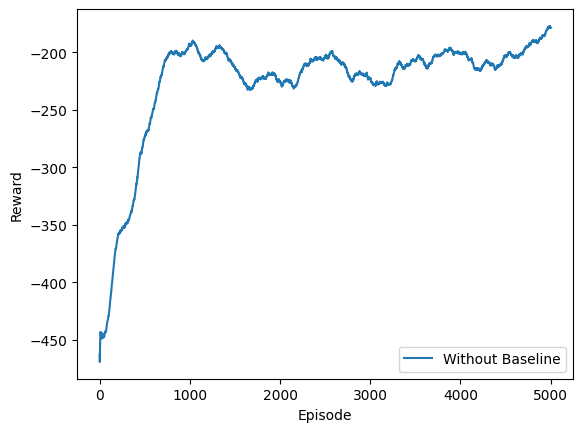

In [ ]:
import matplotlib.pyplot as plt
print("average regret = ",L_without_baseline[0] )
plot_reward_without_baseline =  L_without_baseline[1][:L_without_baseline[2]]

plt.plot(plot_reward_without_baseline, label='Without Baseline')

plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()

In [ ]:
L_with_baseline = avg_over_5_runs(params_with_baseline)

{'LR': 0.0002264, 'network_size': 64} Its just getting started 
Ep: 400 last 100 episodes reward is  : -345.15
Ep: 800 last 100 episodes reward is  : -256.25
Ep: 1200 last 100 episodes reward is  : -197.74
Ep: 1600 last 100 episodes reward is  : -159.12
Ep: 2000 last 100 episodes reward is  : -131.65
Ep: 2400 last 100 episodes reward is  : -118.23
Ep: 2800 last 100 episodes reward is  : -105.22
Ep: 3200 last 100 episodes reward is  : -94.19
Ep: 3600 last 100 episodes reward is  : -91.57
Ep: 4000 last 100 episodes reward is  : -95.31
Ep: 4400 last 100 episodes reward is  : -88.67
Ep: 4800 last 100 episodes reward is  : -85.78
0 {'LR': 0.0002264, 'network_size': 64} 818779.1532035717
{'LR': 0.0002264, 'network_size': 64} 818779.1532035717
Ep: 400 last 100 episodes reward is  : -395.52
Ep: 800 last 100 episodes reward is  : -282.0
Ep: 1200 last 100 episodes reward is  : -218.68
Ep: 1600 last 100 episodes reward is  : -172.41
Ep: 2000 last 100 episodes reward is  : -134.11
Ep: 2400 last 10

average regret =  2261903.082916007


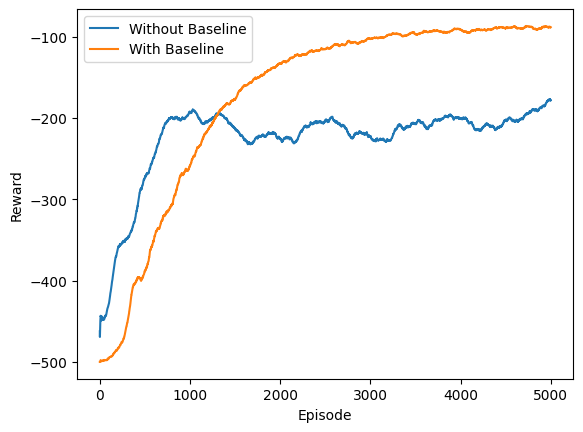

In [ ]:
import matplotlib.pyplot as plt
print("average regret = ",L_without_baseline[0] )
plot_reward_without_baseline =  L_without_baseline[1][:L_without_baseline[2]]
plot_reward_with_baseline =  L_with_baseline[1][:L_with_baseline[2]]
plt.plot(plot_reward_without_baseline, label='Without Baseline')
plt.plot(plot_reward_with_baseline, label='With Baseline')
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()

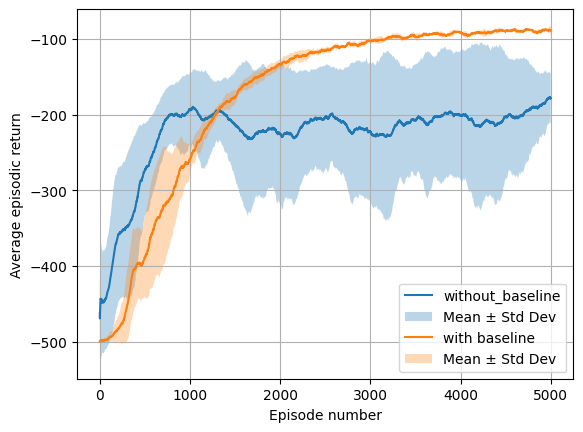

In [ ]:
without_baseline_list=L_without_baseline[-1]
means_without_baseline = [np.mean(sublist) for sublist in without_baseline_list]
std_devs_without_baseline = [np.std(sublist) for sublist in without_baseline_list]
means_with_baseline = [np.mean(sublist) for sublist in L_with_baseline[-1]]
std_devs_with_baseline = [np.std(sublist) for sublist in L_with_baseline[-1]]
plt.plot(means_without_baseline, label='without_baseline')
plt.fill_between(range(len(means_without_baseline)), np.subtract(means_without_baseline, std_devs_without_baseline), np.add(means_without_baseline, std_devs_without_baseline), alpha=0.3, label='Mean ± Std Dev')
plt.plot(means_with_baseline, label='with baseline')
plt.fill_between(range(len(means_with_baseline)), np.subtract(means_with_baseline, std_devs_with_baseline), np.add(means_with_baseline, std_devs_with_baseline), alpha=0.3, label='Mean ± Std Dev')
plt.xlabel('Episode number')
plt.ylabel('Average episodic return')
#plt.title('Mean and Standard Deviation of Sublists')
plt.legend()
plt.grid(True)
plt.show()